In [1]:
#Data
#Bike rental system with subscription
#We want to predict for a given time and day , how many people will rent a bike in front of Andrea's house - 
#                      so he knows if any bikes will be left for him


In [128]:
from importlib import reload
import mglearn
reload(mglearn.datasets)
 
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures

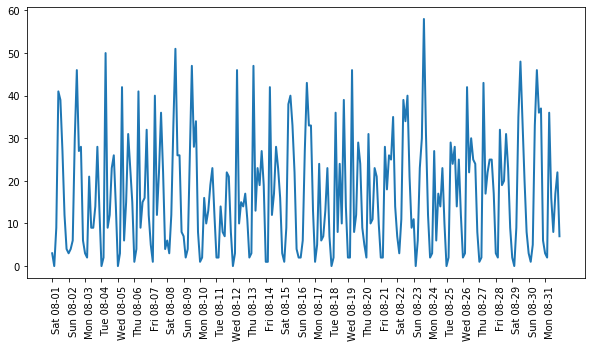

In [108]:
citibike = mglearn.datasets.load_citibike()


plt.figure(figsize=(10,5))
xticks = pd.date_range(start = citibike.index.min(), end = citibike.index.max(), freq='D')
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha='left')
plt.plot(citibike, linewidth=2)

In [57]:
citibike.count()

248

In [89]:
#248 data points - 184 train set(23 days) and 64 test set(8 days)

#extract target values
y = citibike.values
X = citibike.index.strftime("%s").astype("int").values.reshape(-1,1)


In [93]:

def eval_on_features(features, target, regressor):
    n_train = 184
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]
    
    regressor.fit(X_train, y_train)
    print("Test set R^2: ", regressor.score(X_test, y_test))
    
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    
    plt.figure(figsize=(10,5))
    plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90, ha='left')
    
    plt.plot(range(n_train), y_train, label='Train', linewidth= 2)
    plt.plot(range(n_train, len(y_test)+ n_train ), y_test, label='Test', linewidth=2)
    plt.plot(range(n_train), y_pred_train, label='prediction train', linewidth = 2)
    plt.plot(range(n_train, len(y_test)+ n_train), y_pred, label = 'prediction test', linewidth = 2)
    plt.legend(loc = (1.01,0))
    



Test set R^2:  -0.035486463625959086


<Figure size 432x288 with 0 Axes>

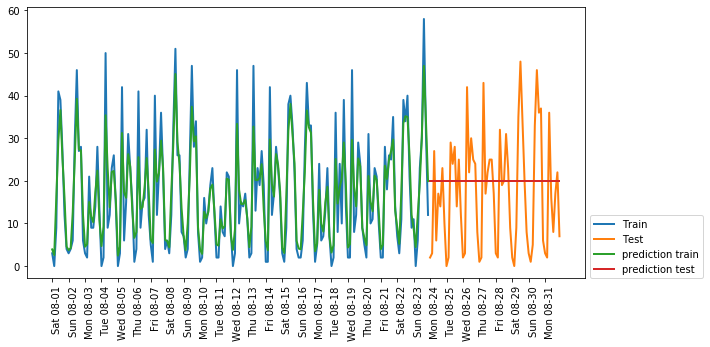

In [94]:
#RandomForest did good with training set but not with test set. It did worse on test set
#Test set consisted of timestamp after training set and 
#RandomForest is not capable of extrapolating outside of features values in training set


regressor = RandomForestRegressor(n_estimators=100, random_state=0)
plt.figure()
eval_on_features(X,y,regressor)

Test set R^2:  0.5995775993305429


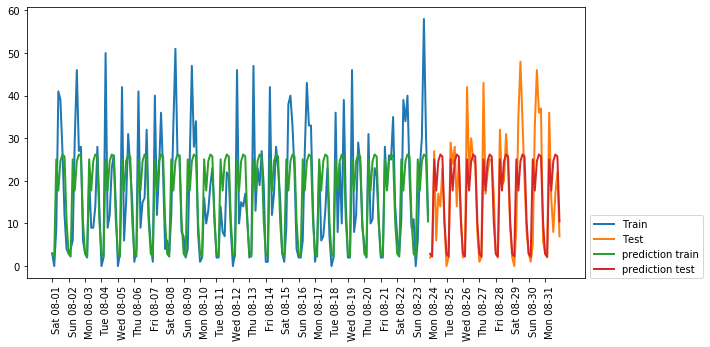

In [103]:
#2 factors  - time of the day and day of the week
#Making time of the day as a feature

#Prediction is better - same patter for each day of the week
#prediction clearly miss the weekly pattern


X_hour = citibike.index.hour.values.reshape(-1,1)
eval_on_features(X_hour, y, regressor)

Test set R^2:  0.8419488587966025


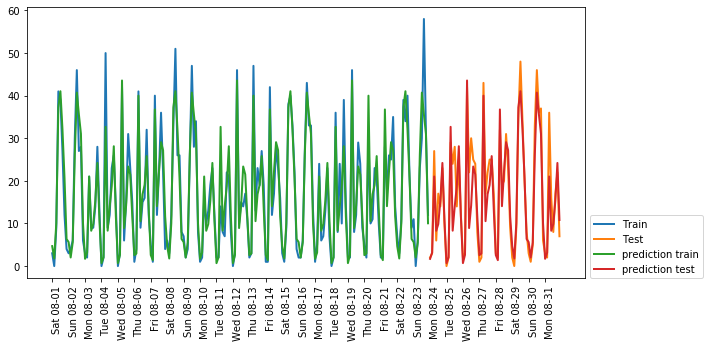

In [114]:
#Now pretty good performance

X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1,1) , citibike.index.hour.values.reshape(-1,1)])
eval_on_features(X_hour_week, y, regressor)


Test set R^2:  0.13204157262163152


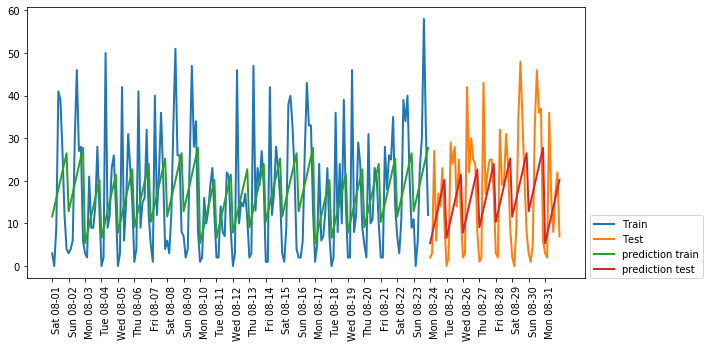

In [116]:
#Trying linear regression on this

#LR works much worse
#LR took interger values of time of day and day of week as categorical

regressor = LinearRegression()
eval_on_features(X_hour_week, y, regressor)

Test set R^2:  0.6191139168658686


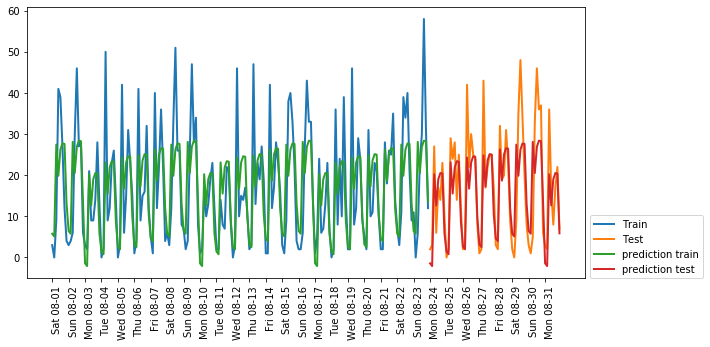

In [129]:
#Now it learn one coefficient for each time of the day and day of the week, time of the day is shared

enc = OneHotEncoder()
X_hour_week_enc = enc.fit_transform(X_hour_week).toarray()

eval_on_features(X_hour_week_enc, y, Ridge())


Test set R^2:  0.8451706357968556


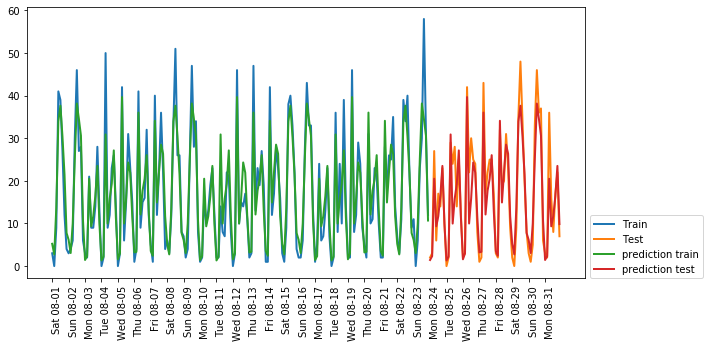

In [147]:
#Using interation features, we can learn one coefficient for each combination for time of day and day of week

#Now it perform almost like random forest

poly = PolynomialFeatures(degree =2, interaction_only = True, include_bias = False)
X_hour_week_enc_poly = poly.fit_transform(X_hour_week_enc)
lr = Ridge()
eval_on_features(X_hour_week_enc_poly, y, lr)

In [182]:
#Now plotting coefficients learned by the model

hour = ["%02d:00" %i for i in range(0,24,3)]
day = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
features =  day+hour

features_poly = poly.get_feature_names(features)
features_nonzero = np.array(features_poly)[lr.coef_!=0]
coeff_nonzero = lr.coef_[lr.coef_!=0]

Features


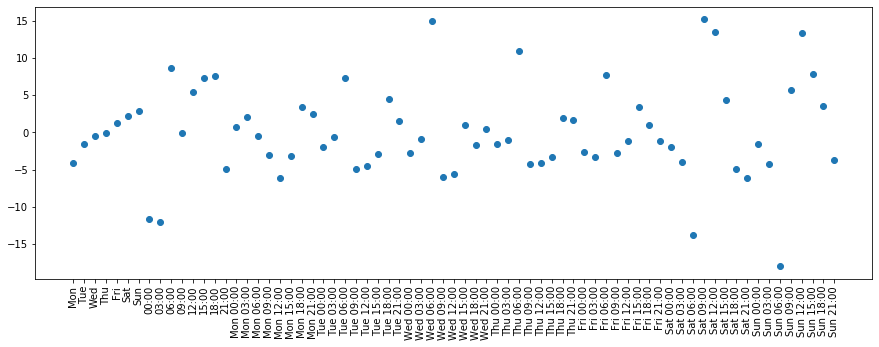

In [183]:
plt.figure(figsize=(15,5))
plt.plot(coeff_nonzero,'o')
plt.xticks(np.arange(len(coeff_nonzero)), features_nonzero, rotation=90)
print("Features")